In [1]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import MetaTrader5 as mt
import scipy as sp


import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

import MetaTrader5 as mt

import warnings
warnings.filterwarnings('ignore')

mt.initialize()

login_mt5 = 1051534030
mdp_mt5 = 'FG2SF2M74R'
server = 'FTMO-Demo'

mt.login(login_mt5, mdp_mt5, server)

ModuleNotFoundError: No module named 'pandas_datareader'

In [ ]:
with pd.HDFStore('data.h5') as hdf:
    data = hdf['data_rsi_filtre']
    prices = hdf['prices_rsi_filtre']
    relative_spread_cost = hdf['rsi_relative_spread_cost']
    pred = hdf['pred']

In [7]:
symbs = data.index.get_level_values(0).unique()
list_of_spread = []
thrld = 4e-5
for symb in symbs:
    bid = mt.symbol_info_tick(symb).bid
    ask = mt.symbol_info_tick(symb).ask
    spread = (ask - bid) / (ask + bid / 2)
    list_of_spread.append([symb, spread])

list_of_spread = pd.DataFrame(list_of_spread, columns = ['tickers', 'spread'])
tickers = list_of_spread[list_of_spread.spread < thrld].tickers.to_list()

In [3]:
tickers = ['GBPJPY', 'GBPUSD', 'EURGBP', 'EURUSD', 'USDCAD', 'USDJPY']

In [4]:
data = data.loc[tickers]
prices = prices.loc[tickers]
relative_spread_cost = relative_spread_cost.loc[tickers]
pred = pred.loc[tickers]

In [5]:
pred = pred.reindex(prices.index).fillna(value=0)

In [7]:
spread = prices.pop('spread')
percentage_spreads = prices.pop('percentage_spreads')
prices.columns = ['open', 'high', 'low', 'close', 'volume']

In [8]:
data = pd.concat([prices, pred, relative_spread_cost, percentage_spreads], axis=1)

In [9]:
data = data.drop(['actuals'], axis=1)

In [10]:
data = data.dropna()
data.columns = ['open', 'high', 'low', 'close', 'volume', 'predicted', 'relative_spread', 'spread']

In [11]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']


class VariableSpreadCommission(bt.CommInfoBase):
    params = (('spread_percentage', None),)  # Remplacez 'None' par la ligne de spread dans vos données si nécessaire

    def _getcommission(self, size, price, pseudoexec):
        # Obtenir le spread en pourcentage pour la barre temporelle actuelle
        spread_percentage = self.p.spread_percentage[0]

        # Calculer le spread en points pour le prix donné
        spread = price * spread_percentage

        # Ajuster le prix d'exécution en fonction du sens de l'ordre (achat ou vente)
        if size > 0:  # Achat
            price += spread / 2
        elif size < 0:  # Vente
            price -= spread / 2

        # Calculer et retourner la commission basée sur le prix ajusté
        return abs(size) * price * self.p.commission


class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted', 'relative_spread', 'spread']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())
    
class MLStrategy(bt.Strategy):
    
    def __init__(self):
        
        self.start_time = datetime.time(hour=3, minute=0)
        self.end_time = datetime.time(hour=22, minute=0)
        self.rsd_critic_value = 0.1
        self.position_needed = 1
        self.bar_counters = {}
        self.pos_size = []
        tickers = ['GBPJPY', 'GBPUSD', 'EURGBP', 'EURUSD', 'USDCAD', 'USDJPY']
        for ticker in tickers:
    
            self.bar_counters[ticker] = 0
            
        self.max_time = 10

    def next(self):
        
        
        ordres_ouverts = self.broker.get_orders_open()
        for ordre in ordres_ouverts:
            self.cancel(ordre)
        # 2 - refresh bar_counters
        
        for data in self.datas:
            self.bar_counters[data._name] += 1
        positions_to_close = []
        
        # 3 - get positions to close
        for data in self.datas:
            pos = self.getposition(data=data)
            self.pos_size.append(pos.size)
            if pos.size == 0:
                continue
            
            pos_sign = -1 if pos.size < 0 else 1
            pos_preds = -1 if data.predicted[0] < 0 else 1
            positions_to_close.append([data._name, pos_sign, pos_preds])
            
        positions_to_close = pd.DataFrame(positions_to_close, columns=['tickers', 'pos_sign', 'pos_preds'])
        positions_to_close = positions_to_close[positions_to_close.pos_sign != positions_to_close.pos_preds].tickers.to_list() 
        
        # 4 - close positions only if position time > max_time
        for data in self.datas:
            if self.bar_counters[data._name] > self.max_time and data._name in positions_to_close:
                pos = self.getposition(data=data)
                pos_sign = -1 if pos.size < 0 else 1
                price_to_execute = data.close[0] if pos_sign == -1 else data.close[0]
                self.close(data=data._name, 
                           exectype=bt.Order.Market)
                
        # 5 - initialise list of ticker in position and position_size
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        position_size = 1/self.position_needed
        # 6 - Only if the hour of the day is within the previously defined bounds
        
        if self.start_time <= bt.num2date(self.datas[0].datetime[0]).time() <= self.end_time:
            
            # 7 - Select tickers with best relative spread
            
            
            # 8 - Select top predictions
            
            top_quantile = []
            for data in self.datas:
                top_quantile.append([data._name, data.predicted[0]])
            
            top_quantile = pd.DataFrame(top_quantile, columns=['symbol', 'predicted'])
            top_quantile['predicted'] = top_quantile.predicted.abs()
            ticker_selected = (top_quantile.sort_values(by='predicted', ascending=False)
                               .iloc[:max(self.position_needed - len(positions), 0)]
                               .symbol
                               .to_list())
            # 9 - Submit orders
            
            for data in self.datas:
                if data._name in positions:
                    print(data._name, self.bar_counters[data._name])
                if data._name in ticker_selected and data._name not in positions:
                    size = self.broker.getvalue() * position_size / data.close[0]
                    if data.predicted[0] > 0 and data.relative_spread[0] < self.rsd_critic_value:
                        
                        self.buy(exectype=bt.Order.Market, 
                                 data=data._name,
                                 size=size)
                        self.bar_counters[data._name] = 0
                    
                    if data.predicted[0] < 0 and data.relative_spread[0] < self.rsd_critic_value:
                        
                        self.sell(exectype=bt.Order.Market, 
                                  data=data._name, 
                                  size=size)
                        self.bar_counters[data._name] = 0

In [12]:
class RSIStrategy(bt.Strategy):
    
    def __init__(self):
        
        self.start_time = datetime.time(hour=3, minute=0)
        self.end_time = datetime.time(hour=22, minute=0)
        self.rsd_critic_value = 1
        self.position_needed = 10
        self.capital = 100000
        self.bar_counters = {}
        tickers = ['AUDJPY', 'AUDUSD','GBPJPY','GBPUSD',
                   'EURAUD','EURGBP','EURCAD','EURJPY',
                   'EURCHF','EURUSD','CHFJPY','USDCAD',
                   'USDCHF','USDJPY']
        for ticker in tickers:
    
            self.bar_counters[ticker] = 0
            
        self.max_time = 60

    def next(self):
        for data in self.datas:
            self.bar_counters[data._name] += 1
        
        for data in self.datas:
            pos = self.getposition(data=data)
            if self.bar_counters[data._name] > self.max_time and pos != 0:
                self.order_target_percent(data=data._name, target=0)
        
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        position_size = 1/self.position_needed
        print(positions)
        
        if self.start_time <= bt.num2date(self.datas[0].datetime[0]).time() <= self.end_time:
            
            predicted_check = np.array([])
            for data in self.datas:
                predicted_check = np.append(predicted_check, data.predicted[0])
            if not (predicted_check == 0).all():
                
                top_quantile = []
                for data in self.datas:
                    top_quantile.append([data._name, data.predicted[0]])

                top_quantile = pd.DataFrame(top_quantile, columns=['symbol', 'predicted'])
                top_quantile['predicted'] = top_quantile.predicted.abs()
                top_quantile = top_quantile[top_quantile.predicted != 0]
                ticker_selected = (top_quantile.sort_values(by='predicted', ascending=False)
                                   .iloc[:self.position_needed - len(positions)]
                                   .symbol
                                   .to_list())
                for data in self.datas:
                    if data._name in ticker_selected and ticker_selected not in positions:

                        if data.predicted[0] > 0:
                            self.order_target_percent(data=data._name, target=position_size)                         
                            self.bar_counters[data._name] = 0

                        if data.predicted[0] < 0:
                            self.order_target_percent(data=data._name, target=-position_size)
                            self.bar_counters[data._name] = 0
                            
                    else:
                        pos = self.getposition(data=data)
                        if pos.size == 0:
                            continue
                        elif (pos.size > 0 and data.predicted[0] > 0) or (pos.size < 0 and data.predicted[0] < 0):
                            self.bar_counters[data._name] = 0


In [13]:
class PortfolioValueAnalyzer(bt.Analyzer):
    def __init__(self):
        self.portfolio_values = []

    def next(self):
        self.portfolio_values.append(self.strategy.broker.getvalue())
        
class SizeValueAnalyzer(bt.Analyzer):
    
    def __init__(self):
        
        self.pos_size = {}
        
    def start(self):
        
        self.pos_size = {}
    
    def next(self):
        
        for data in self.strategy.datas:
            pos = self.strategy.getposition(data=data)
            ticker = str(data._name)
            actual = 0 if self.pos_size.get(ticker) is None else self.pos_size.get(ticker)
            if pos.size > actual:
                self.pos_size[ticker] = pos.size
            

In [14]:
cerebro = bt.Cerebro()
cash = 100000
cerebro.broker.set_cash(cash)

In [15]:
lower_date_threshold = pd.Timestamp('2023-01-01')
higher_date_threshold = pd.Timestamp('2023-05-09')
data.index.names = ['symbol', 'date']
data_after_date = data[(data.index.get_level_values('date') >= lower_date_threshold) & 
                       (data.index.get_level_values('date') <= higher_date_threshold)]

In [16]:
for ticker in data_after_date.index.get_level_values(0).unique():
    df = data_after_date.loc[ticker]
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)
    #spread_commission = VariableSpreadCommission(spread_percentage=bt_data.lines.spread)
    #cerebro.broker.addcommissioninfo(spread_commission, name=ticker)
    cerebro.broker.setcommission(commission=3.5e-05, name=ticker)

In [18]:
portfolio_values = np.array(results[0].analyzers.getbyname('portfolio_value').portfolio_values)

In [ ]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(PortfolioValueAnalyzer, _name='portfolio_value')
cerebro.addanalyzer(SizeValueAnalyzer, _name='SizeValue')#bt.analyzers.PyFolio, _name='pyfolio'
cerebro.addstrategy(MLStrategy)
results = cerebro.run()
ending_value = cerebro.broker.getvalue()

print(f'Final Portfolio Value: {ending_value:,.2f}')

In [19]:
pf_returns = np.diff(portfolio_values) / portfolio_values[:-1]

In [20]:
pd.DataFrame(portfolio_values, columns=['pf_value'], index=data.index.get_level_values(1).unique()).to_csv('portfolio_values')

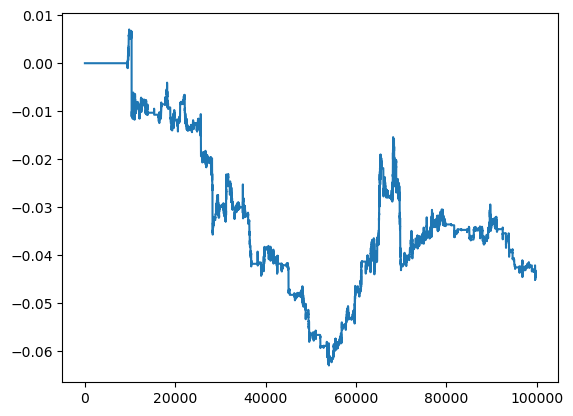

In [21]:
plt.plot(pf_returns.cumsum())

In [ ]:
pos_size = results[0].analyzers.getbyname('SizeValue').pos_size
pos_size

In [ ]:
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [ ]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions)